In [1]:
from torchvision import models
from PIL import Image

import torchvision
import os
import subprocess
import matplotlib.pyplot as plt
import torch
import requests
import time

plt.style.use('ggplot')

In [2]:
# Load the FCN Resnet101 sementation model
fcn = models.segmentation.fcn_resnet101(
    weights=torchvision.models.segmentation.FCN_ResNet101_Weights.DEFAULT
).eval()

Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /Users/research/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [01:01<00:00, 3.57MB/s] 


In [3]:
# Helper function to download image and other files.
# Helper function to download file.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        subprocess.run(['wget', url, '-O', save_name, '-q'])

In [4]:
# Create directory to store inference data
inference_dir = 'inference_data'
os.makedirs(inference_dir, exist_ok=True)

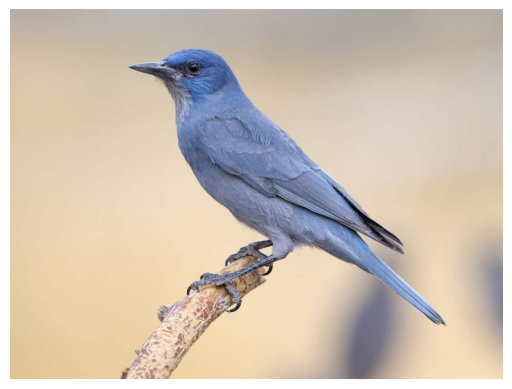

In [6]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/bird.jpg',
    save_name=os.path.join(inference_dir, 'bird.jpg')
)
img = Image.open(os.path.join(inference_dir, 'bird.jpg'))
plt.imshow(img)
plt.axis("off")
plt.show()


In [7]:
import torchvision.transforms as T
trf = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )
])
inp = trf(img).unsqueeze(0)

In [8]:
out  = fcn(inp)['out']
print(out.shape)

torch.Size([1, 21, 224, 224])


In [9]:
import numpy as np

om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print(om.shape)
print(np.unique(om))

(224, 224)
[0 3]


In [16]:
def decode_segmap(image, nc=21):
    label_colors = np.array([
        (0, 0, 0),       # 0=background
        (128, 0, 0),     # 1=aeroplane
        (0, 128, 0),     # 2=bicycle 
        (128, 128, 0),   # 3=bird, 
        (0, 0, 128),     # 4=boat
        (128, 0, 128),   # 5=bottle
        (0, 128, 128),   # 6=bus 
        (128, 128, 128), # 7=car 
        (64, 0, 0),      # 8=cat
        (192, 0, 0),     # 9=chair
        (64, 128, 0),    # 10=cow
        (192, 128, 0),   # 11=dining table
        (64, 0, 128),    # 12=dog
        (192, 0, 128),   # 13=horse
        (64, 128, 128),  # 14=motorbike
        (192, 128, 128), # 15=person
        (0, 64, 0),      # 16=potted plant 
        (128, 64, 0),    # 17=sheep
        (0, 192, 0),     # 18=sofa 
        (128, 192, 0),   # 19=train 
        (0, 64, 128)     # 20=tv/monitor
    ])
    
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

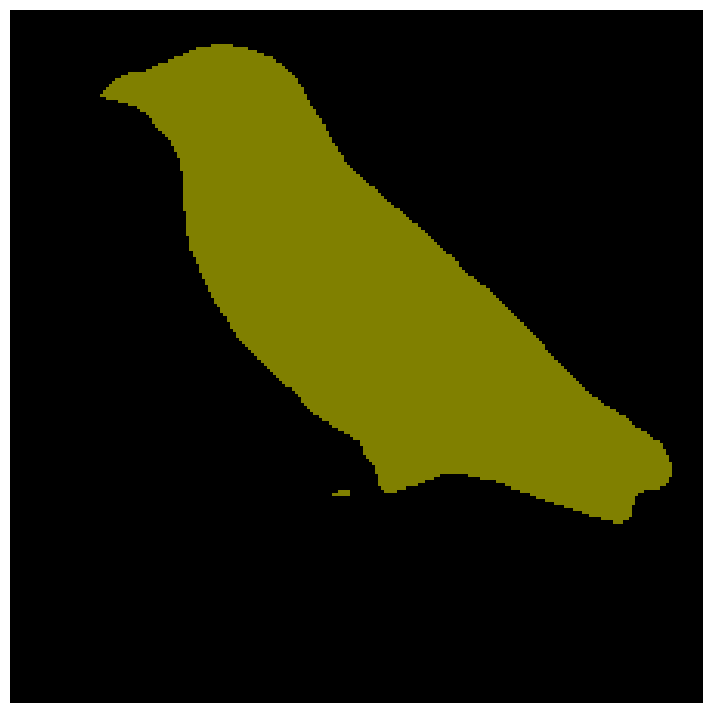

In [17]:
rgb = decode_segmap(om)
plt.figure(figsize=(12, 9))
plt.imshow(rgb)
plt.axis('off')
plt.show()

In [18]:
def segment(net, path, show_orig=True, dev='cuda'):
    plt.figure(figsize=(10, 7))
    img = Image.open(path)
    if show_orig:
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(640),
                   #T.CenterCrop(224),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    plt.figure(figsize=(10, 7))
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

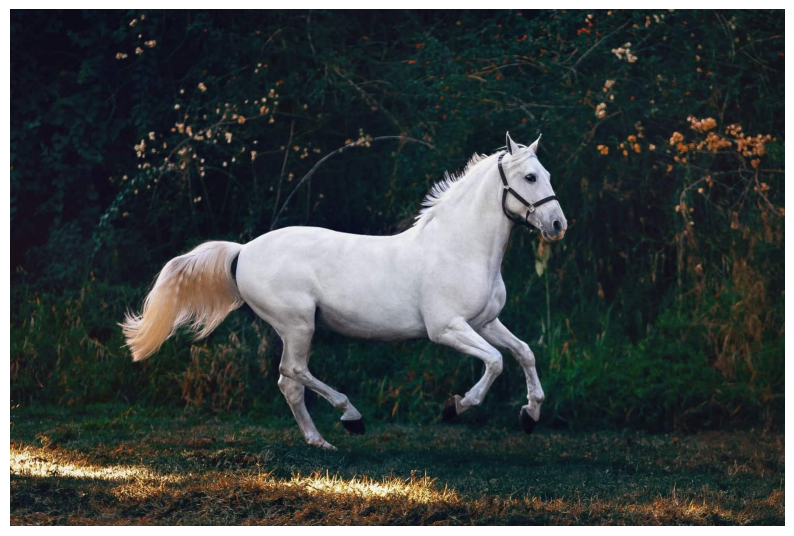

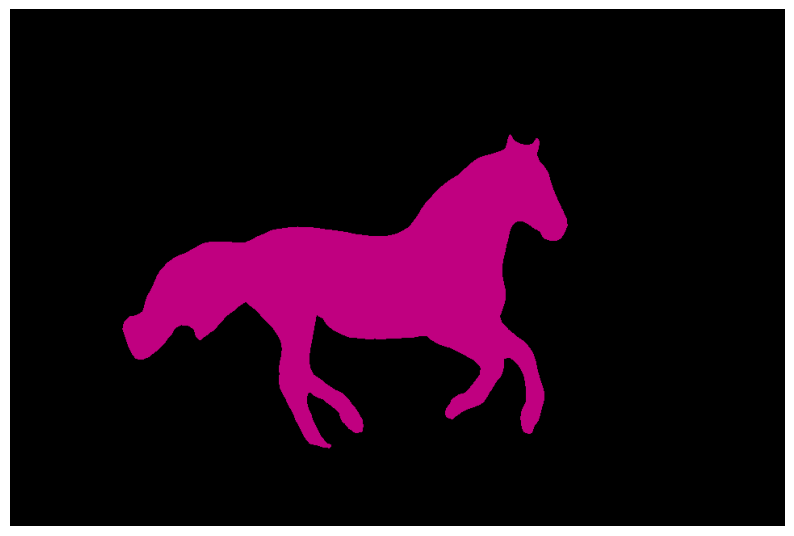

In [22]:
download_file(
    'https://www.learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg',
     save_name=os.path.join(inference_dir, 'horse.jpg')
)
segment(fcn, os.path.join(inference_dir, 'horse.jpg'), dev="cpu")

In [23]:
dlab = models.segmentation.deeplabv3_resnet101(
    weights='COCO_WITH_VOC_LABELS_V1'
).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /Users/research/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [01:03<00:00, 3.88MB/s] 


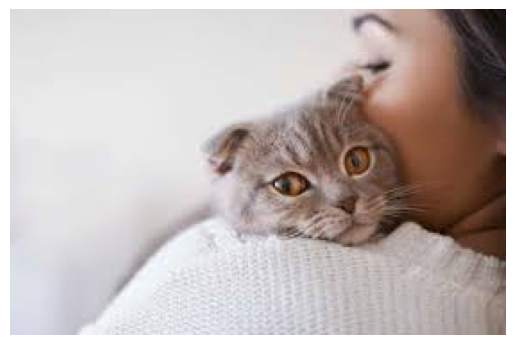

Segementation Image on FCN


<Figure size 1000x700 with 0 Axes>

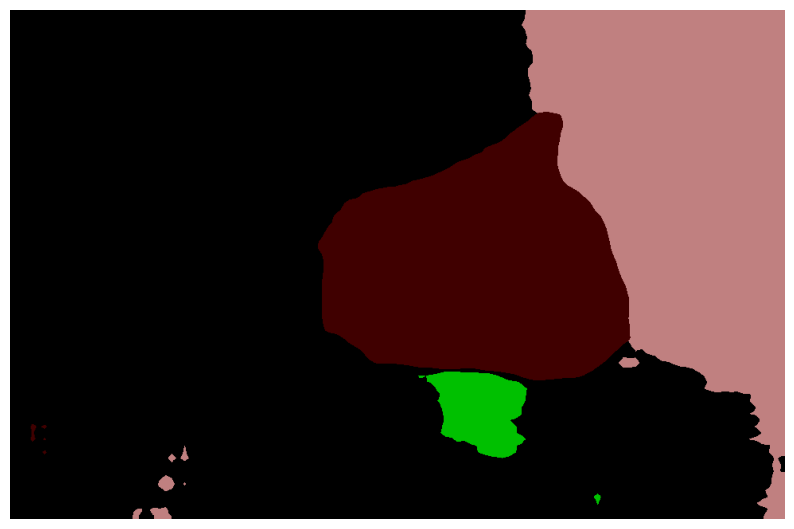

Segementation Image on DeepLabV3


<Figure size 1000x700 with 0 Axes>

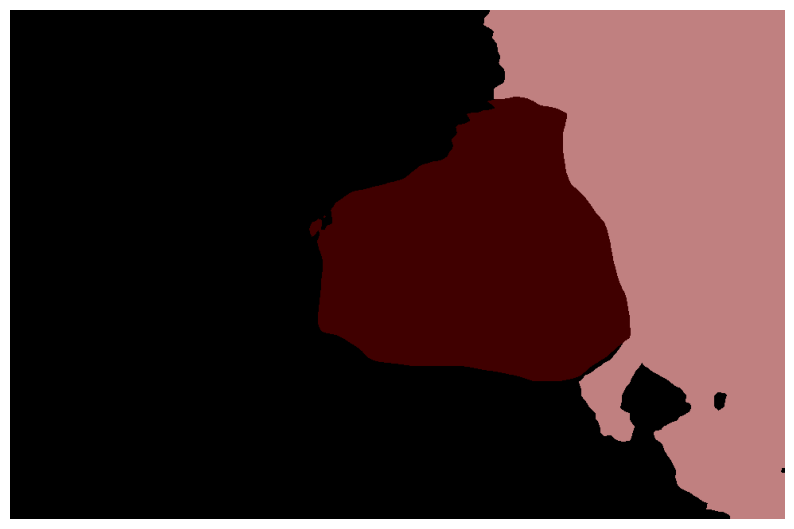

In [31]:
file_name = 'cats.webp'
# download_file(
#     'https://www.learnopencv.com/wp-content/uploads/2021/01/person-segmentation.jpeg',
#     save_name=os.path.join(inference_dir, file_name)
# )
img = Image.open(os.path.join(inference_dir, file_name))
plt.imshow(img)
plt.axis('off')
plt.show()

print('Segementation Image on FCN')
segment(fcn, path=os.path.join(inference_dir, file_name), show_orig=False, dev='mps')

print('Segementation Image on DeepLabV3')
segment(dlab, path=os.path.join(inference_dir, file_name), show_orig=False, dev='mps')

In [32]:
def infer_time(net, path=os.path.join(inference_dir, 'horse.jpg'), dev='cuda'):
    img = Image.open(path)
    trf = T.Compose([T.Resize(256),
                   T.CenterCrop(224),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])

    inp = trf(img).unsqueeze(0).to(dev)

    st = time.time()
    out1 = net.to(dev)(inp)
    et = time.time()

    return et - st

In [33]:
avg_over = 100

fcn_infer_time_list_cpu = [infer_time(fcn, dev='cpu') for _ in range(avg_over)]
fcn_infer_time_avg_cpu = sum(fcn_infer_time_list_cpu) / avg_over

dlab_infer_time_list_cpu = [infer_time(dlab, dev='cpu') for _ in range(avg_over)]
dlab_infer_time_avg_cpu = sum(dlab_infer_time_list_cpu) / avg_over


print ('Inference time for first few calls for FCN      : {}'.format(fcn_infer_time_list_cpu[:10]))
print ('Inference time for first few calls for DeepLabv3: {}'.format(dlab_infer_time_list_cpu[:10]))

print ('The Average Inference time on FCN is:     {:.2f}s'.format(fcn_infer_time_avg_cpu))
print ('The Average Inference time on DeepLab is: {:.2f}s'.format(dlab_infer_time_avg_cpu))

Inference time for first few calls for FCN      : [1.6593539714813232, 0.15387511253356934, 0.16293883323669434, 0.15047287940979004, 0.13942718505859375, 0.12949490547180176, 0.19854378700256348, 0.23556303977966309, 0.15921878814697266, 0.17776203155517578]
Inference time for first few calls for DeepLabv3: [3.5446228981018066, 0.16157197952270508, 0.347369909286499, 0.18435096740722656, 0.21964383125305176, 0.1542341709136963, 0.1562941074371338, 0.1495969295501709, 0.15755414962768555, 0.15470504760742188]
The Average Inference time on FCN is:     0.15s
The Average Inference time on DeepLab is: 0.20s


In [34]:
avg_over = 100

fcn_infer_time_list_gpu = [infer_time(fcn, dev='mps') for _ in range(avg_over)]
fcn_infer_time_avg_gpu = sum(fcn_infer_time_list_gpu) / avg_over

dlab_infer_time_list_gpu = [infer_time(dlab, dev='mps') for _ in range(avg_over)]
dlab_infer_time_avg_gpu = sum(dlab_infer_time_list_gpu) / avg_over

print ('Inference time for first few calls for FCN      : {}'.format(fcn_infer_time_list_gpu[:10]))
print ('Inference time for first few calls for DeepLabv3: {}'.format(dlab_infer_time_list_gpu[:10]))

print ('The Average Inference time on FCN is:     {:.3f}s'.format(fcn_infer_time_avg_gpu))
print ('The Average Inference time on DeepLab is: {:.3f}s'.format(dlab_infer_time_avg_gpu))

Inference time for first few calls for FCN      : [3.8808481693267822, 0.11788392066955566, 0.05527901649475098, 0.055298805236816406, 0.0572359561920166, 0.05504798889160156, 0.0549468994140625, 0.05508899688720703, 0.05500483512878418, 0.05551505088806152]
Inference time for first few calls for DeepLabv3: [0.3721799850463867, 0.07828712463378906, 0.06507492065429688, 0.06599593162536621, 0.06594038009643555, 0.06598877906799316, 0.06503415107727051, 0.06541109085083008, 0.06812596321105957, 0.06784272193908691]
The Average Inference time on FCN is:     0.098s
The Average Inference time on DeepLab is: 0.069s


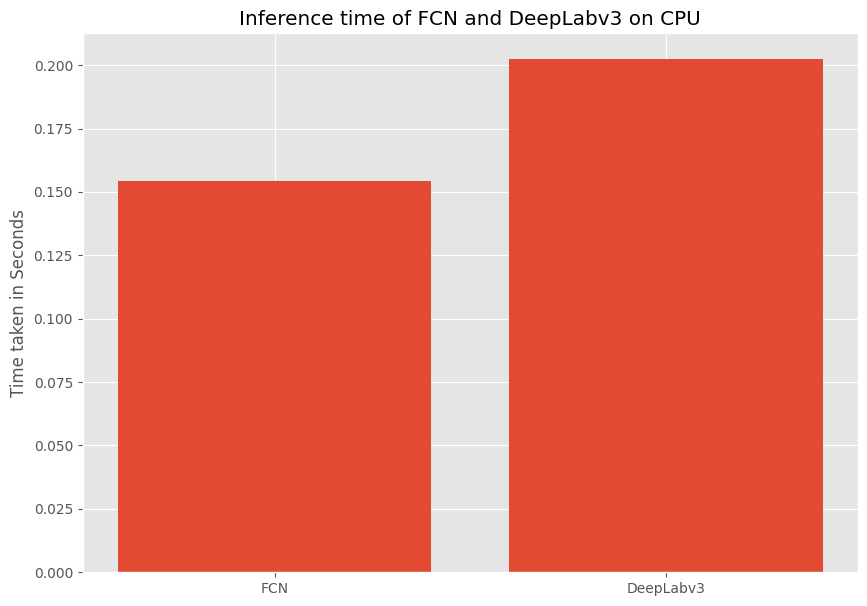

In [35]:
plt.figure(figsize=(10, 7))
plt.bar([0.1, 0.2], [fcn_infer_time_avg_cpu, dlab_infer_time_avg_cpu], width=0.08)
plt.ylabel('Time taken in Seconds')
plt.xticks([0.1, 0.2], ['FCN', 'DeepLabv3'])
plt.title('Inference time of FCN and DeepLabv3 on CPU')
plt.show()

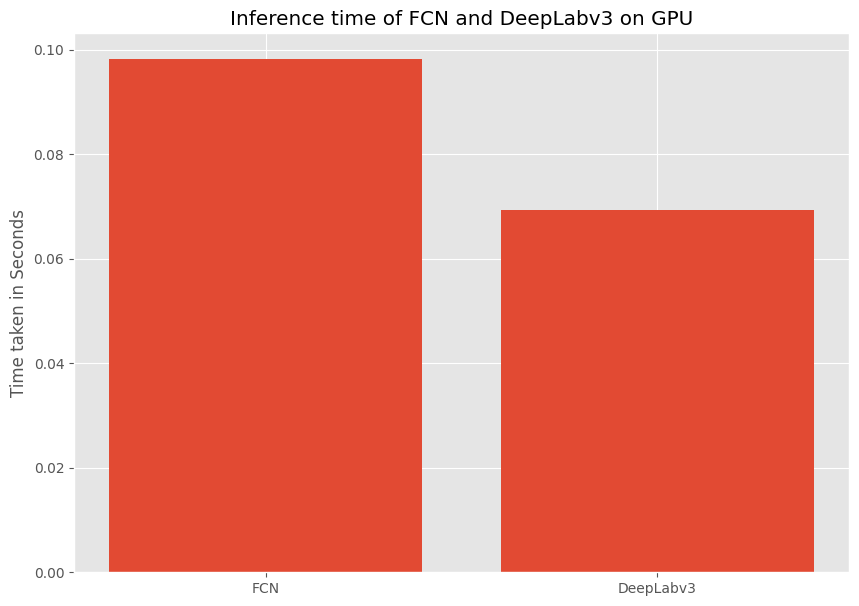

In [36]:
plt.figure(figsize=(10, 7))
plt.bar([0.1, 0.2], [fcn_infer_time_avg_gpu, dlab_infer_time_avg_gpu], width=0.08)
plt.ylabel('Time taken in Seconds')
plt.xticks([0.1, 0.2], ['FCN', 'DeepLabv3'])
plt.title('Inference time of FCN and DeepLabv3 on GPU')
plt.show()